In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, TensorDataset, DataLoader
from torchvision import models
from torchvision.datasets import MNIST
from torchvision.transforms import v2

c:\Users\Ngu\mambaforge\envs\ml_env\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\Ngu\mambaforge\envs\ml_env\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Load data

In [3]:
train_ds = MNIST(root="../data", train=True, download=True)
test_ds = MNIST(root="../data", train=False, download=True)
display(train_ds)
display(test_ds)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test

## Split data

In [4]:
# Splitting to train and valid
train_ds, val_ds = random_split(train_ds, [50000, 10000])
print("Train size: ", len(train_ds))
print("Val size: ", len(val_ds))
print("Test size: ", len(test_ds))

Train size:  50000
Val size:  10000
Test size:  10000


## Data augmentation

I will replicate the grayscale image 3 times to create a 3-channel image. This is because our pretrained model expects 3-channel images.

In [5]:
class MyDataset(Dataset):
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.ds[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.ds)

In [6]:
train_transform = v2.Compose([
    v2.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.ColorJitter(brightness=0.2, contrast=0.2),
    v2.ToImageTensor(), v2.ConvertDtype(),
    v2.Lambda(lambda x: torch.cat([x, x, x], 0))
])

val_transform = v2.Compose([
    v2.ToImageTensor(), v2.ConvertDtype(),
    v2.Lambda(lambda x: torch.cat([x, x, x], 0))
])

test_transform = val_transform

train_ds = MyDataset(train_ds, train_transform)
val_ds = MyDataset(val_ds, val_transform)

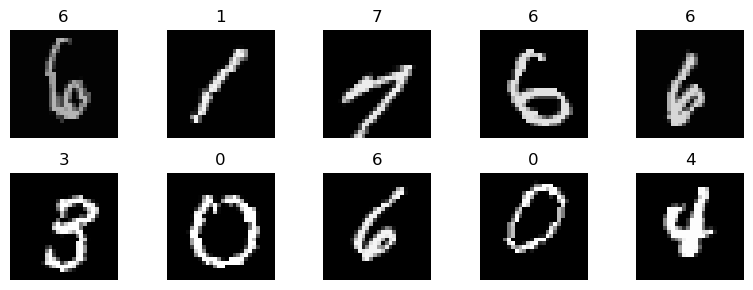

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(8, 3))

for i, ax in enumerate(axes.flat):
    image, label = train_ds[i]
    ax.imshow(image.squeeze().permute(1, 2, 0), cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()

## Model: ResNet18 architecture

We fine-tune a ResNet18 model, trained on ImageNet. Other models might be used, but for the purpose of this notebook a ResNet18 is a good trade-off between training time and model accuracy.
The model originally has a 512-dimensional output layer, but our dataset has only 10 classes, so we remove the output layer and define a new Fully-Connected layer with just 10 neurons, one for each class in CIFAR-10. The parameters of these new neurons are initialized with Xavier initialization.

In [8]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)
        torch.nn.init.xavier_uniform_(self.model.fc.weight)
    
    def forward(self, x):
        return self.model(x)

When fine-tuning, the model parameters of the network body are trained using a lower learning rate than for the head, since for the latter we have to train them from scratch. We rely on Parameter Groups from PyTorch to define two learning rates for the two groups, and use Adam optimizer with weight_decay = 5e-4 (find via hyperparameter search).

In [9]:
lr, weight_decay = 1e-5, 5e-4

model = ResNet()
model.to(device)

params_1x = [param for name, param in model.named_parameters() if 'fc' not in str(name)]
opt = torch.optim.Adam([{'params': params_1x}, {'params': model.model.fc.parameters(), 'lr': lr * 10}], lr=lr, weight_decay=weight_decay)

loss_func = F.cross_entropy

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True)

c:\Users\Ngu\mambaforge\envs\ml_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ngu\mambaforge\envs\ml_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
model

ResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

## Training loop

In [11]:
def accuracy(preds, y_true): 
    return (torch.argmax(preds, dim=1) == y_true).float().mean()

In [12]:
from tqdm import tqdm

epochs = 10
train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in tqdm(range(epochs)):
    epoch_loss, acc = 0, 0
    model.train()
    for Xb, yb in train_loader:
        Xb = Xb.to(device)
        yb = yb.to(device)
        
        preds = model(Xb)
        loss = loss_func(preds, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

        epoch_loss += loss.item()
        acc += accuracy(preds, yb)

    train_loss.append(epoch_loss / len(train_loader))
    train_acc.append(acc / len(train_loader))


    epoch_loss, acc = 0, 0
    model.eval()
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(device)
            yb = yb.to(device)
            
            preds = model(Xb)
            loss = loss_func(preds, yb)

            epoch_loss += loss.item()
            acc += accuracy(preds, yb)

    val_loss.append(epoch_loss / len(val_loader))
    val_acc.append(acc / len(val_loader))

    print(
        f"Epoch [{epoch+1}/{epochs}], ",
        f"Train loss: {train_loss[-1]:.4f}, ",
        f"Train acc: {train_acc[-1]:.4f}, ",
        f"Val loss: {val_loss[-1]:.4f}, ",
        f"Val acc: {val_acc[-1]:.4f}",
    )

 10%|█         | 1/10 [11:09<1:40:24, 669.37s/it]

Epoch [1/10],  Train loss: 1.2061,  Train acc: 0.6217,  Val loss: 0.3465,  Val acc: 0.8932


 20%|██        | 2/10 [22:28<1:29:59, 674.98s/it]

Epoch [2/10],  Train loss: 0.4173,  Train acc: 0.8684,  Val loss: 0.1399,  Val acc: 0.9586


 30%|███       | 3/10 [34:09<1:20:08, 686.90s/it]

Epoch [3/10],  Train loss: 0.2476,  Train acc: 0.9232,  Val loss: 0.0907,  Val acc: 0.9738


 40%|████      | 4/10 [44:58<1:07:12, 672.15s/it]

Epoch [4/10],  Train loss: 0.1938,  Train acc: 0.9390,  Val loss: 0.0667,  Val acc: 0.9795


 50%|█████     | 5/10 [56:13<56:04, 672.97s/it]  

Epoch [5/10],  Train loss: 0.1513,  Train acc: 0.9525,  Val loss: 0.0569,  Val acc: 0.9832


 60%|██████    | 6/10 [1:06:59<44:15, 663.92s/it]

Epoch [6/10],  Train loss: 0.1262,  Train acc: 0.9612,  Val loss: 0.0534,  Val acc: 0.9835


 70%|███████   | 7/10 [1:18:08<33:16, 665.53s/it]

Epoch [7/10],  Train loss: 0.1126,  Train acc: 0.9646,  Val loss: 0.0474,  Val acc: 0.9847


 80%|████████  | 8/10 [1:29:10<22:08, 664.43s/it]

Epoch [8/10],  Train loss: 0.0973,  Train acc: 0.9697,  Val loss: 0.0427,  Val acc: 0.9873


 90%|█████████ | 9/10 [1:39:12<10:44, 644.88s/it]

Epoch [9/10],  Train loss: 0.0897,  Train acc: 0.9718,  Val loss: 0.0361,  Val acc: 0.9893


100%|██████████| 10/10 [1:49:27<00:00, 656.70s/it]

Epoch [10/10],  Train loss: 0.0800,  Train acc: 0.9749,  Val loss: 0.0362,  Val acc: 0.9889


In [13]:
X_test = torch.stack([test_transform(image) for image in test_ds.data])
y_test = test_ds.targets

In [14]:
model.eval()
accuracy(model(X_test), y_test)


tensor(0.9904)

In [15]:
torch.save(model, "../models/resnet18_finetune.pth")

tensor(7)
tensor(7)
tensor([[-6.2363, -0.0404,  0.0223, -4.0056,  0.1797, -2.2600, -3.1522, 11.8789,
         -4.0404,  3.0870]], grad_fn=<AddmmBackward0>)


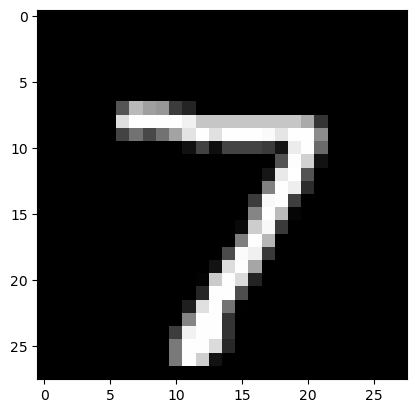

In [16]:
num = 0
print(y_test[num])
print(torch.argmax(model(X_test[num].unsqueeze(0))))
print(model(X_test[num].unsqueeze(0)))
plt.imshow(X_test[num].squeeze().permute(1, 2, 0), cmap="gray")